## Implementation of rotation


Now we want to be able to specify the position of a camera. We will use 4x4 matrices to that end. 
The first three rows and columns represents the rotation matrix, the three frist rows on the last column is the translation.
We'll simply apply the matrix by matrix multiplication to rays_o and rays_d

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch

H=400 #height og image
W=400 #width of image
f=1200 #focal length


In [26]:
c2w1 = np.array([0.34303784370422363,
                 -0.8594792485237122,
                 0.3789729177951813,
                 3.7897279262542725,
                 0.9393215775489807,
                 0.3138796091079712,
                 -0.13839992880821228,
                 -1.3840025663375854,
                 0.0,
                 0.40345385670661926,
                 0.9150000214576721,
                 9.149999618530273,
                 0.0,
                 0.0,
                 0.0,
                 1.0])
c2w1 = c2w1.reshape((4, 4))


c2w2 = np.array([-0.7053813934326172,
                -0.5776947736740112,
                0.41073814034461975,
                4.1073899269104,
                0.7088279724121094,
                -0.5748858451843262,
                0.4087409973144531,
                4.087401390075684,
                0.0,
                0.5794609785079956,
                0.8149999976158142,
                8.149999618530273,
                0.0,
                0.0,
                0.0,
                1.0])
c2w2 = c2w2.reshape((4, 4))

In [27]:

rays_o=np.zeros((H*W,3)) #ray origin for every pixel, 3D
rays_d=np.zeros((H*W,3)) #ray direction for every pixel, 3D

u = np.arange(W) #u is the x axis
v = np.arange(H) #v is the y axis

u,v=np.meshgrid(u,v) #create a grid of u and v

dirs = np.stack((u-W/2,
                -(v-H/2),
                -np.ones_like(u)*f), axis=-1) #direction of the rays, y and z are reversed wrt to image below
# dirs represents the vector from the focal point to the pixel
# to make it really a direction, we need to normalize it

dirs = (c2w1[:3,:3]@dirs[...,None]).squeeze(-1) #rotate the direction vectors

rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) #normalize the direction vectors
rays_d=rays_d.reshape(-1,3)

rays_o+=c2w1[:3,-1] #add the translation vector to the ray origin

In [28]:
def plot_rays(o,d,t):
    fig=plt.figure(figsize=(12,12))
    ax= fig.add_subplot(projection="3d")

    pt1 = o #origin of ray
    pt2=o+t*d #where the head of the vector is after time t

    for p1,p2 in zip(pt1[::100], pt2[::100]): # plot one in 100 rays, will result in pyramids
        plt.plot([p1[0], p2[0]], [p1[1],p2[1]], [p1[2],p2[2]])

    #plt.plot([pt1[0,0], pt2[0,0]], [pt1[0,1],pt2[0,1]], [pt1[0,2],pt2[0,2]])

    plt.show()

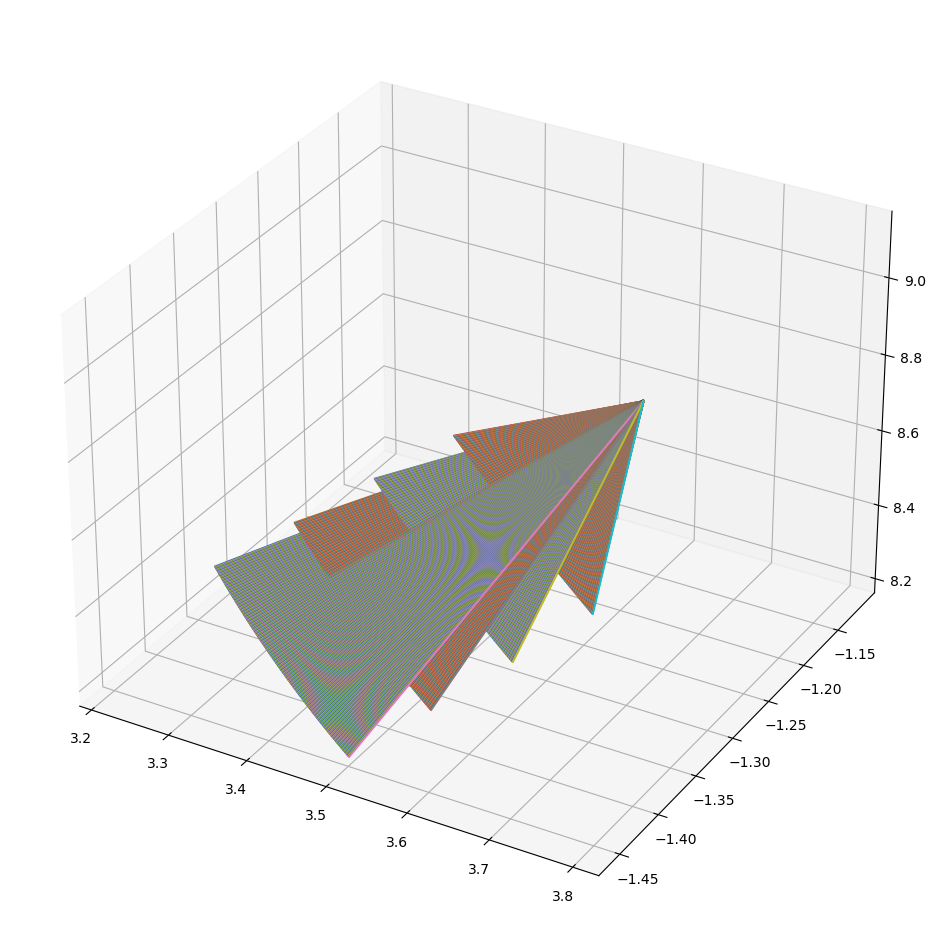

In [29]:
plot_rays(rays_o,rays_d,1) #The camera has moved from the origin and it has rotated
#It is looking towards the origin

In [47]:
class Sphere():
    def __init__(self, p, r, c1, c2=None):
        self.p=p
        self.r=r
        self.c1=c1
        if c2 is None:
            self.c2=c1
        else:
            self.c2=c2

    def intersect(self, x):
        # Input: x 3D coordinate (rather than ray)
        # output density and color (per point)

        #Let s see how to tell if x is inside a sphere
        cond= (x[:,0]-self.p[0])**2+(x[:,1]-self.p[1])**2+(x[:,2]-self.p[2])**2< self.r**2 
        #p is the center of the sphere, r is the radius
        # if x is on a lower radius sphere, it will be inside the bigger sphere
        
        #half of the ball:
        cond2= x[:,2]<self.p[2]

        num_rays=x.shape[0]

        colors=torch.zeros((num_rays,3)) # standard color assigned to ray
        density=torch.zeros((num_rays,1))

        #color first half of the sphere
        colors[cond & cond2]=self.c1
        # color second half of the sphere
        colors[cond & ~cond2]=self.c2
        
        density[cond]=10
        return colors, density

In [31]:

#volume rendering
def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device="cpu"):
    #tn and tf are borns of integral (each are scalar?)
    #nb_bins is the number of points sampled?
    #rays_o origin of rays, Dim=(H*W,3)

    t=torch.linspace(tn,tf,nb_bins).to(device) # [nb_bins]
    delta=torch.cat((t[1:]-t[:-1] , torch.tensor([1e10]))) # we add infinity value at the end

    # Now we want to compute every point along the rays
    # naive approach:
    # rays_o+t*rays_d but the dimensions don t match

    x=rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1)*rays_d.unsqueeze(1) #[nb_rays,nb_bins,3]
    colors, density = model.intersect(x.reshape(-1,3))

    colors=colors.reshape(x.shape[0],nb_bins,3) # shape [nb_rays, nb_bins, 3]
    density=density.reshape(x.shape[0],nb_bins) # shape [nb_rays, nb_bins]

    alpha=1-torch.exp(-density * delta.unsqueeze(0)) # shape [nb_rays, nb_bins]
    T=accumulated_transmittance(1-alpha)
    print(T.shape)
    c=(T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) #[nb_ray,3]
    return c

In [32]:
def accumulated_transmittance(beta):
    #beta = 1-alpha which is a trick to compute faster
    #input shape [nb_rays, nb_bins]
    #output shape [nb_rays, nb_bins]
    """
    T = torch.ones(beta.shape)
    for i in range(1,beta.shape[1]):
        T[:,i]=T[:,i-1]*beta[:,i-1]
    """

    #can be made faster using cumprod
    
    T=torch.cumprod(beta,1)
    #T[:,1:]=T[:,:-1] # might caus diff problems
    #T[:,0]=1.  might caus diff problems
    

    return torch.cat((torch.ones(T.shape[0],1, device=T.device),T[:,:-1]),dim=1)

Where is the camera?

In [33]:
dist_from_origin=np.linalg.norm(c2w1[:3,-1]) #10


In [48]:
tn=8 # we adapt it to the distance from the origin
tf = 12 # we adapt it to the distance from the origin
nb_bins=100
s=Sphere(torch.tensor([0.,0.,0]), 1, torch.tensor([1.,0.,0.]), torch.tensor([0.,1.,0.]))

In [49]:

px_colors=rendering(s,torch.from_numpy(rays_o), torch.from_numpy(rays_d), tn, tf)

torch.Size([160000, 100])


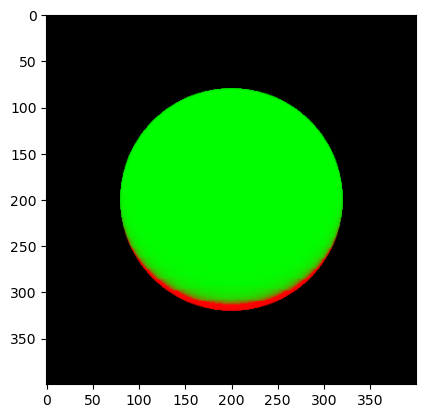

In [50]:
img=px_colors.reshape(H,W,3)
plt.figure(dpi=100)
plt.imshow(img)

Let's make a little test of optimization.
Let's suppose we want to find the right color red starting from green

torch.Size([160000, 100])
torch.Size([160000, 100])


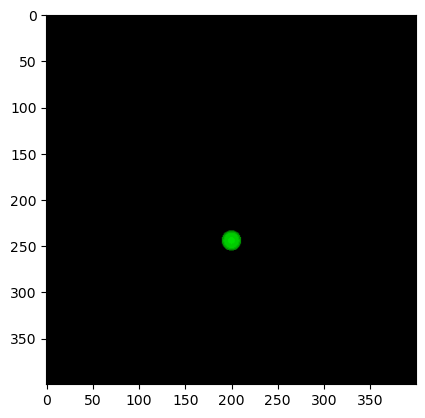

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


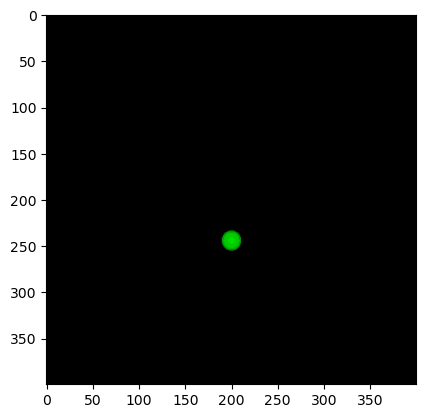

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


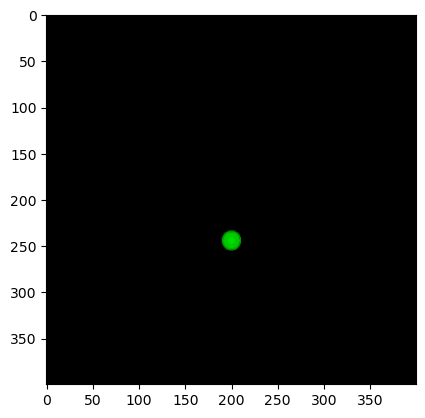

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


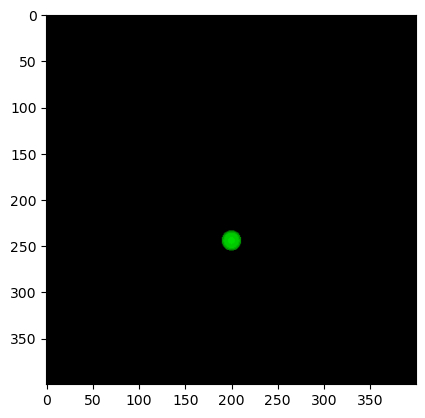

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


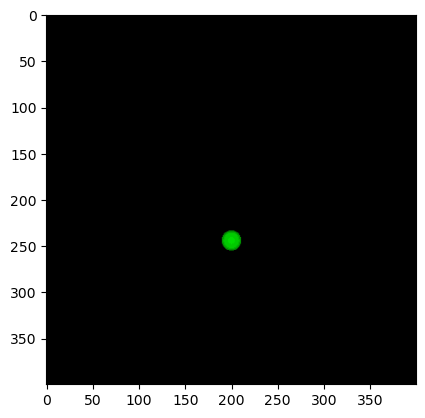

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


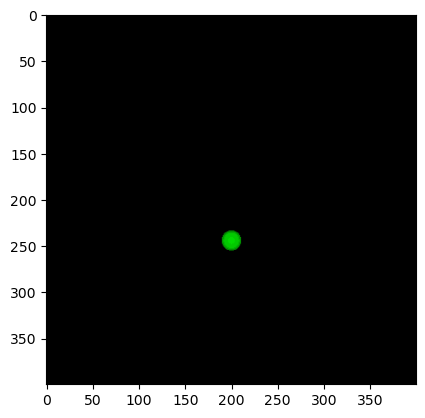

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


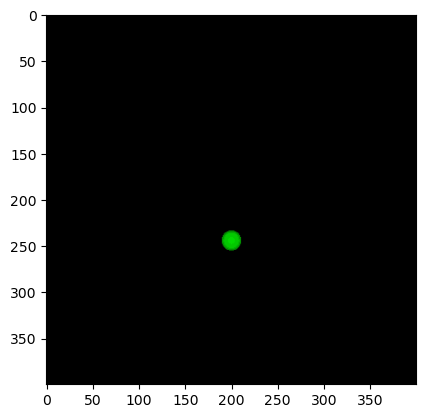

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


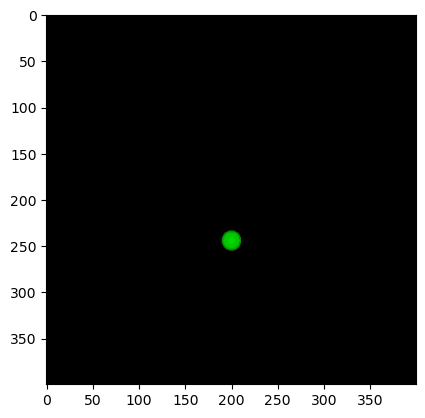

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


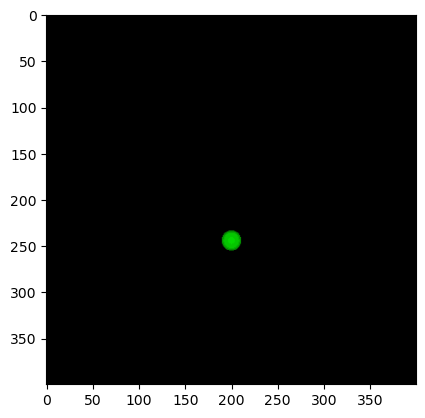

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


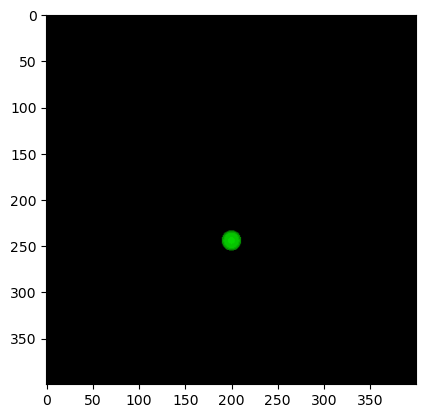

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


In [38]:
color_opt=torch.tensor([0.,1.,0.], requires_grad=True)
s=Sphere(torch.tensor([0.,0.,-1]), .1, torch.tensor([1.,0.,0.]))
x= Sphere(torch.tensor([0.,0.,-1]), .1,color_opt)

b=rendering(s,torch.from_numpy(rays_o),torch.from_numpy(rays_d),tn,tf)

optimizer=torch.optim.SGD({color_opt},lr=1e-2)
for epoch in range(100):
    Ax=rendering(x,torch.from_numpy(rays_o),torch.from_numpy(rays_d),tn,tf)

    loss=((Ax-b)**2).mean()
    loss.backward()
    optimizer.step()

    if epoch %10 ==0:
        img=Ax.reshape(H,W,-1).cpu().data.numpy()
        plt.imshow(img)
        plt.show()




Now we want to be able to specify the position of a camera. We will use 4x4 matrices to that end. 
The first three rows and columns represents the rotation matrix, the three frist rows on the last column is the translation.
We'll simply apply the matrix by matrix multiplication to rays_o and rays_d